<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/code_figure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Figure 3a


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


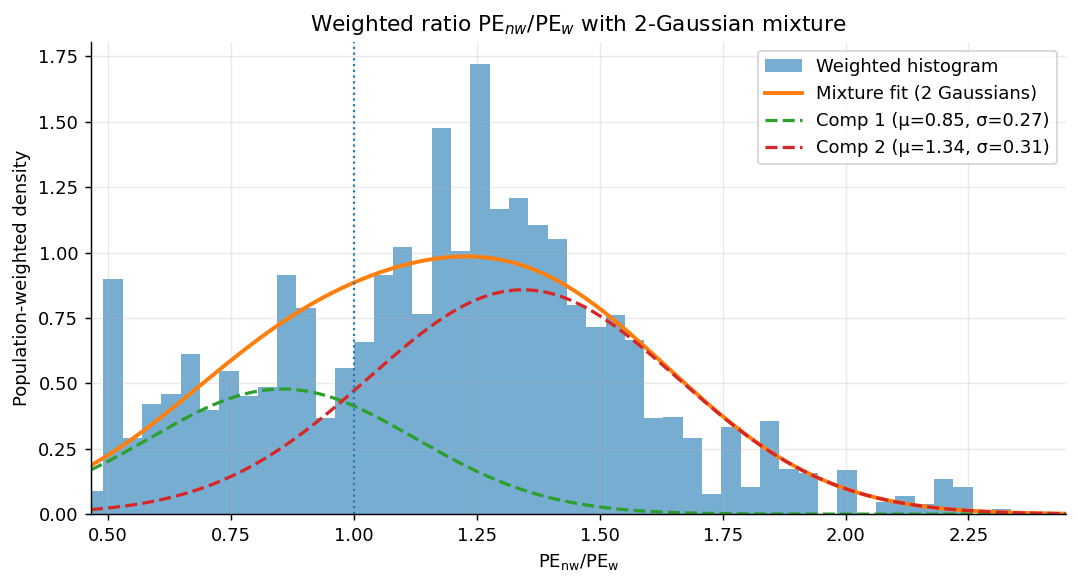

[Cell 3b][GMM] Components (sorted by mean):
 - Comp 1: mean=0.8542 (< 1), std=0.2701, weight=0.3239
 - Comp 2: mean=1.3438 (> 1), std=0.3144, weight=0.6761
Figure saved to /content/drive/MyDrive/FMC_Data/Combined_Figure/PE_nw_PE_w_2_gaussian_mixture.pdf


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Define data directory
data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"

# --- Essential Data Loading for df_pop and dong_ids ---
# Population data
pop_file = os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx")
pop_sheet = "Sheet1"
df_pop = pd.read_excel(pop_file, sheet_name=pop_sheet, engine="openpyxl")
df_pop["dong_cd"] = df_pop["dong_cd"].astype(str)

# Ensure dong_ids are consistently ordered (as used in other cells)
dong_ids = df_pop["dong_cd"].tolist()

# --- Essential Trip Data Processing ---
nw_file = os.path.join(data_dir, "Tij_NonworkTrips_P24567_in2023.xlsx")
w_file  = os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx")

usecols_t = ["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"]
df_T_nw = pd.read_excel(nw_file, usecols=usecols_t, engine="openpyxl")
df_T_w  = pd.read_excel(w_file , usecols=usecols_t, engine="openpyxl")

for dfT in (df_T_nw, df_T_w):
    dfT["O_ADMDONG_CD"] = dfT["O_ADMDONG_CD"].astype(str)
    dfT["D_ADMDONG_CD"] = dfT["D_ADMDONG_CD"].astype(str)
    dfT["CNT"] = pd.to_numeric(dfT["CNT"], errors="coerce").fillna(0.0)

# --- Essential PE Calculations and GMM Plotting ---
# ----- Build dense T matrices in the consistent dong order -----
def build_dense_T(dfT, dong_ids):
    """Return dense matrix T (n x n) in order of dong_ids."""
    idx_map = {d: i for i, d in enumerate(dong_ids)}
    n = len(dong_ids)
    T = np.zeros((n, n), dtype=float)
    for (o, d), cnt in dfT.groupby(["O_ADMDONG_CD", "D_ADMDONG_CD"])[("CNT")].sum().items():
        i = idx_map.get(o)
        j = idx_map.get(d)
        if i is not None and j is not None:
            T[i, j] = float(cnt)
    return T

# ----- Compute PE -----
def compute_PE(T):
    """PE(i) = sum_j T_ji / sum_{m,n} T_{mn}."""
    total = T.sum()
    IT = T.sum(axis=0)  # incoming per destination i
    with np.errstate(divide="ignore", invalid="ignore"):
        PE = np.where(total > 0, IT / total, 0.0)
    return PE, IT, total

# Build the dense trip matrices
T_nw = build_dense_T(df_T_nw, dong_ids)
T_w  = build_dense_T(df_T_w , dong_ids)

# Compute PE_nw and PE_w
PE_nw, IT_nw, total_nw = compute_PE(T_nw)
PE_w , IT_w , total_w  = compute_PE(T_w )

# Assemble per-dong frame for PE and merge with population
df_SC_PE = pd.DataFrame({
    "dong_cd": dong_ids,
    "PE_nw": PE_nw,
    "PE_w": PE_w
})
df_SC_PE = df_SC_PE.merge(
    df_pop[["dong_cd", "defacto_pop"]],
    on="dong_cd", how="left"
)

# Extract PE_w, PE_nw, and defacto_pop as NumPy arrays
PEw = df_SC_PE["PE_w"].to_numpy(float)
PEnw = df_SC_PE["PE_nw"].to_numpy(float)
popw = df_SC_PE["defacto_pop"].astype(float).to_numpy()

mask = np.isfinite(PEw) & np.isfinite(PEnw)
PEw_v, PEnw_v, popw_v = PEw[mask], PEnw[mask], popw[mask]

# Calculate ratio_raw (PE_nw / PE_w) and w_r
ratio_raw = np.divide(PEnw_v, PEw_v, out=np.full_like(PEw_v, np.nan), where=(PEw_v > 0))
mask_r = np.isfinite(ratio_raw) & (ratio_raw > 0)
r = ratio_raw[mask_r]
w_r = popw_v[mask_r]

# Scale weights and reshape for GMM
if r.size > 1 and np.nansum(w_r) > 0:
    # Approximate weighted fit: replicate observations proportional to normalized weights
    w_scaled = np.clip((w_r / np.nanmax(w_r)) * 200, 1, None).astype(int)
    r_rep = np.repeat(r, w_scaled).reshape(-1, 1)

    # Initialize and fit GaussianMixture model
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(r_rep)

    # Extract GMM components and sort
    means = gmm.means_.flatten()
    stds  = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_.flatten()
    order = np.argsort(means)
    means, stds, weights = means[order], stds[order], weights[order]

    # Define plotting range and _gauss helper function
    xmin = max(0.0, float(np.nanpercentile(r, 0.5)))
    xmax = min(5.0, 1.10 * float(np.nanpercentile(r, 99.5)))
    x = np.linspace(xmin, xmax, 600)

    def _gauss(x, mu, sig):
        return (1.0 / (np.sqrt(2*np.pi) * sig)) * np.exp(-0.5 * ((x - mu) / sig)**2)

    # Calculate combined mixture density
    mix = weights[0]*_gauss(x, means[0], stds[0]) + weights[1]*_gauss(x, means[1], stds[1])

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8.4, 4.6))

    # Plot histogram
    ax.hist(r, bins=60, density=True, weights=w_r, alpha=0.6, label="Weighted histogram")

    # Plot combined mixture fit and individual Gaussian components
    ax.plot(x, mix, lw=2.2, label="Mixture fit (2 Gaussians)")
    ax.plot(x, weights[0]*_gauss(x, means[0], stds[0]), lw=1.8, linestyle="--",
            label=f"Comp 1 (\u03bc={means[0]:.2f}, \u03c3={stds[0]:.2f})")
    ax.plot(x, weights[1]*_gauss(x, means[1], stds[1]), lw=1.8, linestyle="--",
            label=f"Comp 2 (\u03bc={means[1]:.2f}, \u03c3={stds[1]:.2f})")

    # Add vertical line at x=1.0
    ax.axvline(1.0, linestyle=":", lw=1.2)

    # Set labels, title, and legend
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r"$\mathrm{PE}_{\mathrm{nw}}/\mathrm{PE}_{\mathrm{w}}$")
    ax.set_ylabel("Population-weighted density")
    ax.set_title(r"Weighted ratio $\mathrm{PE}_{nw}/\mathrm{PE}_{w}$ with 2-Gaussian mixture")
    ax.legend()
    try:
        plt.tight_layout()
    except Exception:
        pass
    # Display the plot
    plt.show()

    print("[Cell 3b][GMM] Components (sorted by mean):")
    for k_comp in range(2):
        side = "< 1" if means[k_comp] < 1 else "> 1"
        print(f" - Comp {k_comp+1}: mean={means[k_comp]:.4f} ({side}), std={stds[k_comp]:.4f}, weight={weights[k_comp]:.4f}")
else:
    print("[Cell 3b][GMM] Skipped: insufficient finite ratio data or weights.")

output_file = "/content/drive/MyDrive/FMC_Data/Combined_Figure/PE_nw_PE_w_2_gaussian_mixture.pdf"
fig.savefig(output_file, bbox_inches='tight')
print(f"Figure saved to {output_file}")